In [5]:
import sys
sys.path.append('/host/d/Github')
import os
import numpy as np
import pandas as pd
import nibabel as nb
import SimpleITK as sitk
import shutil
from scipy.ndimage import binary_erosion, distance_transform_edt
import Aorta_segmentation_ZC.functions_collection as ff
import Aorta_segmentation_ZC.Data_processing as Data_processing

In [9]:
patient_list = pd.read_excel('/host/d/Data/CTA/Patient_lists/resampled_data_info_with_train_test_split.xlsx')
patient_list = patient_list[patient_list['batch']=='test']
print(patient_list.shape)

save_path = '/host/d/projects/aorta_seg/models/Dataset502_Aorta/results/EncUNetM_3d_lowres/predicts'

(20, 13)


In [ ]:
# fold = 0
# for idx in range(patient_list.shape[0]):
#     patient_class = patient_list.iloc[idx]['class']
#     patient_subclass = patient_list.iloc[idx]['subclass']
#     patient_id = patient_list.iloc[idx]['id']
#     patient_index = patient_list.iloc[idx]['patient_index']

#     save_folder = os.path.join(save_path,  patient_class, patient_subclass, patient_id, 'fold_'+str(fold))
#     ff.make_folder([os.path.join(save_path, patient_class),
#                     os.path.join(save_path, patient_class, patient_subclass),
#                     os.path.join(save_path, patient_class, patient_subclass, patient_id),
#                     save_folder])
    
#     # original path filename is Aorta_XXXX where XXXX is the patient_index with leading zeros
#     original_path = os.path.join(os.path.dirname(save_path), 'predicts_raw/fold_'+str(fold), 'Aorta_' + str(patient_index).zfill(4) + '.nii.gz')
#     save_filename = os.path.join(save_folder,'pred_seg.nii.gz')

#     shutil.copyfile(original_path, save_filename)



### quantitative evaluation

In [10]:
patient_list = pd.read_excel('/host/d/Data/CTA/Patient_lists/resampled_data_info_with_train_test_split.xlsx')
patient_list = patient_list[patient_list['batch']=='test']
print(patient_list.shape)

pred_path = '/host/d/projects/aorta_seg/models/Dataset502_Aorta/results/EncUNetM_3d_lowres/predicts'
gt_path = '/host/d/Data/CTA/original_data/'

(20, 13)


In [11]:
def HD_95_numpy(pred,gt,spacing):
    pred = pred.astype(bool)
    gt = gt.astype(bool)

    # surface voxels
    pred_surf = pred ^ binary_erosion(pred)
    gt_surf = gt ^ binary_erosion(gt)

    dt_gt = distance_transform_edt(~gt_surf, sampling=spacing)
    dt_pred = distance_transform_edt(~pred_surf, sampling=spacing)

    d_pred_gt = dt_gt[pred_surf]
    d_gt_pred = dt_pred[gt_surf]

    hd95=max(np.percentile(d_pred_gt,95), np.percentile(d_gt_pred,95))

    return hd95

In [ ]:
results = []
for idx in range(patient_list.shape[0]):
   patient_class = patient_list.iloc[idx]['class']
   patient_subclass = patient_list.iloc[idx]['subclass']
   patient_id = patient_list.iloc[idx]['id']
   patient_index = patient_list.iloc[idx]['patient_index']
    
   pred_filename = os.path.join(pred_path,  patient_class, patient_subclass, patient_id, 'fold_0', 'pred_seg.nii.gz')
   gt_filename = os.path.join(gt_path, patient_class, patient_subclass, patient_id,'seg_resampled.nii.gz')

   pred_seg = nb.load(pred_filename).get_fdata()

   gt_seg = nb.load(gt_filename)
   pixel_spacing = gt_seg.header.get_zooms()
   print('pixel spacing:', pixel_spacing)
   gt_seg = gt_seg.get_fdata()
  
   if np.unique(gt_seg).shape[0]>2:
      gt_seg[gt_seg>0] = 1  # convert to binary mask

   dice_socre = ff.np_categorical_dice(pred_seg, gt_seg, target_class=1)
   hd = HD_95_numpy(pred_seg, gt_seg, spacing=pixel_spacing)

   print('for patient_class: ', patient_class, ', subclass: ', patient_subclass, ', id: ', patient_id)
   print('Dice score: ', dice_socre)
   print('HD 95: ', hd)

   results.append([patient_index, patient_class, patient_subclass, patient_id, dice_socre, hd])
   df = pd.DataFrame(results, columns=['patient_index', 'class', 'subclass', 'id', 'dice_score', 'hd'])
   df.to_excel(os.path.join(os.path.dirname(pred_path), 'quantitative_fold0.xlsx'), index=False)

  

pixel spacing: (0.7578125, 0.7578125, 0.8)
for patient_class:  AD , subclass:  AD , id:  cta02s
Dice score:  0.9231369868526406
HD 95:  4.917872630566975
pixel spacing: (0.796875, 0.796875, 0.8)


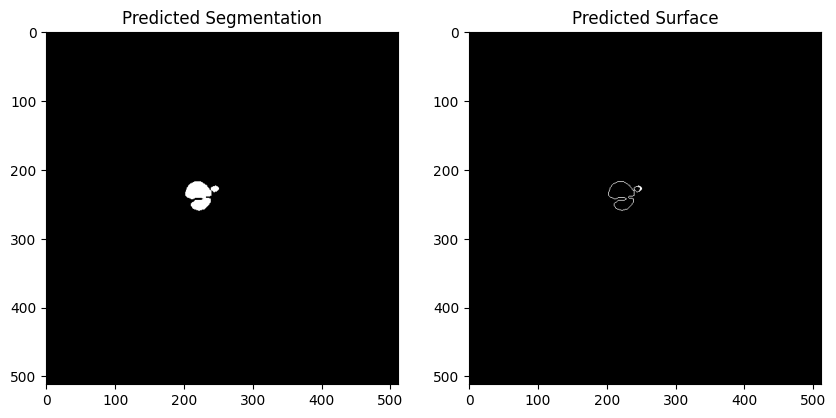

In [ ]:
# from scipy.ndimage import binary_erosion, distance_transform_edt
# pred = pred_seg.astype(bool)
# pred_surf = pred ^ binary_erosion(pred)

# # plot pred and pred_surf side by side to check
# import matplotlib.pyplot as plt
# slice_idx = pred.shape[2]//2
# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.imshow(pred[:,:,slice_idx], cmap='gray')
# plt.title('Predicted Segmentation')
# plt.subplot(1,2,2)
# plt.imshow(pred_surf[:,:,slice_idx], cmap='gray')
# plt.title('Predicted Surface')
# plt.show()
